# Overview

In this notebook, I explore a dataset containing data about MOOCs from edX. I start by doing a bit of exploratory data analysis to get a feel for what trends there might be. Next, I create graphs and plots to visualize those trends. I use a simple linear regression to associate words in the course subjects with the numbers of students pursuing certificates in those classes. I conclude with a discussion of limitations and a few ideas of questions that might be interesting to look at in the future.

# Getting started

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import pandas as pd
from pandas import Grouper
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [2]:
df = pd.read_csv("appendix.csv")

# Exploring the dataset

This dataset is provided by Kaggle and describes the data from 4 years (2013-2016) of MOOC offerings on edX. edX is a platform for __M__assive __O__nline __O__pen __C__ourses, which now hosts courses from many universtities.
[Access the data here](https://www.kaggle.com/edx/course-study)

In [3]:
df.columns

Index(['Institution', 'Course Number', 'Launch Date', 'Course Title',
       'Instructors', 'Course Subject', 'Year', 'Honor Code Certificates',
       'Participants (Course Content Accessed)',
       'Audited (> 50% Course Content Accessed)', 'Certified', '% Audited',
       '% Certified', '% Certified of > 50% Course Content Accessed',
       '% Played Video', '% Posted in Forum', '% Grade Higher Than Zero',
       'Total Course Hours (Thousands)', 'Median Hours for Certification',
       'Median Age', '% Male', '% Female', '% Bachelor's Degree or Higher'],
      dtype='object')

There's a lot of information here, including the percent equivalents of most of the metrics.

* Columns 0-7 have information about the course
* Columns 8-18 have information about course enrollment/completion
* Columns 19-22 have information about course 

In [4]:
df.shape

(290, 23)

Unfortunately, there aren't that many classes in this dataset.

In [5]:
# By default, pd won't display all 23 columns, unless I set the max higher.
pd.options.display.max_columns=24

In [6]:
df.head(3)

,Institution,Course Number,Launch Date,Course Title,Instructors,Course Subject,Year,Honor Code Certificates,Participants (Course Content Accessed),Audited (> 50% Course Content Accessed),Certified,% Audited,% Certified,% Certified of > 50% Course Content Accessed,% Played Video,% Posted in Forum,% Grade Higher Than Zero,Total Course Hours (Thousands),Median Hours for Certification,Median Age,% Male,% Female,% Bachelor's Degree or Higher
0,MITx,6.002x,09/05/2012,Circuits and Electronics,Khurram Afridi,"Science, Technology, Engineering, and Mathematics",1,1,36105,5431,3003,15.04,8.32,54.98,83.2,8.17,28.97,418.94,64.45,26.0,88.28,11.72,60.68
1,MITx,6.00x,09/26/2012,Introduction to Computer Science and Programming,"Eric Grimson, John Guttag, Chris Terman",Computer Science,1,1,62709,8949,5783,14.27,9.22,64.05,89.14,14.38,39.50,884.04,78.53,28.0,83.50,16.50,63.04
2,MITx,3.091x,10/09/2012,Introduction to Solid State Chemistry,Michael Cima,"Science, Technology, Engineering, and Mathematics",1,1,16663,2855,2082,17.13,12.49,72.85,87.49,14.42,34.89,227.55,61.28,27.0,70.32,29.68,58.76


In [7]:
df.tail(3)

,Institution,Course Number,Launch Date,Course Title,Instructors,Course Subject,Year,Honor Code Certificates,Participants (Course Content Accessed),Audited (> 50% Course Content Accessed),Certified,% Audited,% Certified,% Certified of > 50% Course Content Accessed,% Played Video,% Posted in Forum,% Grade Higher Than Zero,Total Course Hours (Thousands),Median Hours for Certification,Median Age,% Male,% Female,% Bachelor's Degree or Higher
287,MITx,6.302.0x,08/01/2016,Introduction to Control System Design,"Jacob White, Joe Steinmeyer","Science, Technology, Engineering, and Mathematics",4,0,3937,974,49,24.74,1.24,5.03,12.27,4.72,8.23,15.62,58.50,24.0,91.17,8.83,61.32
288,MITx,6.302.1x,08/01/2016,Introduction to State Space Control,"Jacob White, Joe Steinmeyer","Science, Technology, Engineering, and Mathematics",4,0,1431,208,8,14.54,0.56,3.85,0,3.84,5.73,3.22,62.38,25.0,93.44,6.56,72.31
289,MITx,3.15.3x,08/03/2016,Magnetic Materials and Devices,Caroline Ross,"Science, Technology, Engineering, and Mathematics",4,0,1294,364,38,28.13,2.94,10.44,49.92,4.40,14.30,6.87,40.59,25.0,85.95,14.05,65.78


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290 entries, 0 to 289
Data columns (total 23 columns):
Institution                                     290 non-null object
Course Number                                   290 non-null object
Launch Date                                     290 non-null object
Course Title                                    290 non-null object
Instructors                                     289 non-null object
Course Subject                                  290 non-null object
Year                                            290 non-null int64
Honor Code Certificates                         290 non-null int64
Participants (Course Content Accessed)          290 non-null int64
Audited (> 50% Course Content Accessed)         290 non-null int64
Certified                                       290 non-null int64
% Audited                                       290 non-null float64
% Certified                                     290 non-null float64
% Certified of

Some features are numeric, and others are strings (object). There are no NaN values.

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Year,290.0,3.172414,0.906301,1.00,3.0000,3.000,4.0000,4.00
Honor Code Certificates,290.0,0.813793,0.389946,0.00,1.0000,1.000,1.0000,1.00
Participants (Course Content Accessed),290.0,15344.334483,28207.578733,322.00,3815.0000,7901.500,18038.2500,301082.00
Audited (> 50% Course Content Accessed),290.0,2549.172414,3095.159969,187.00,755.2500,1517.000,3383.0000,25637.00
Certified,290.0,843.810345,1105.594372,0.00,139.5000,395.500,1201.7500,5783.00
% Audited,290.0,24.916966,15.883538,2.63,14.2150,20.425,33.8375,83.96
% Certified,290.0,7.782586,6.972437,0.00,2.4075,5.950,10.6875,33.98
% Certified of > 50% Course Content Accessed,290.0,31.445655,19.751102,0.00,13.4000,31.270,47.6225,77.09
% Posted in Forum,290.0,9.347517,7.517141,0.00,3.9925,7.245,14.1075,35.28
% Grade Higher Than Zero,290.0,21.210379,13.411540,0.00,10.5900,19.605,30.9025,52.35


In [10]:
df[df["Participants (Course Content Accessed)"]>300000]

,Institution,Course Number,Launch Date,Course Title,Instructors,Course Subject,Year,Honor Code Certificates,Participants (Course Content Accessed),Audited (> 50% Course Content Accessed),Certified,% Audited,% Certified,% Certified of > 50% Course Content Accessed,% Played Video,% Posted in Forum,% Grade Higher Than Zero,Total Course Hours (Thousands),Median Hours for Certification,Median Age,% Male,% Female,% Bachelor's Degree or Higher
99,HarvardX,CS50x,01/01/2015,Introduction to Computer Science,David Malan,Computer Science,3,1,301082,25637,1523,8.51,0.51,5.45,67.8,0.0,0.0,275.96,0.0,25.0,77.68,22.32,51.95


There is a huge range of values for the number of participants. Some of these MOOCs are truly massive!

In [11]:
for col in df.columns[0:6]:
    print("{:>30} column contains {:3} unique entries".format(col, len(df[col].unique())))

                   Institution column contains   2 unique entries
                 Course Number column contains 188 unique entries
                   Launch Date column contains 205 unique entries
                  Course Title column contains 202 unique entries
                   Instructors column contains 141 unique entries
                Course Subject column contains   4 unique entries


Of the text columns, course subject and institution are really categoricals. Setting it as a category type can be more space-efficient if this were a larger data set. The date can be set as a datetime object to be able to do things like resampling.

In [12]:
df["Institution"]=df["Institution"].astype("category")
df["Course Subject"]=df["Course Subject"].astype("category")
df["Launch Date"]= pd.to_datetime(df["Launch Date"])

## Correlations

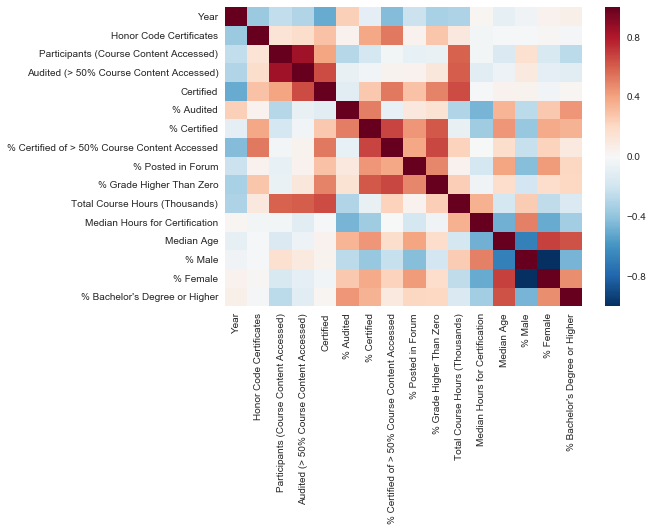

In [13]:
sns.heatmap(df.corr());

Looking at correlations of the numeric columns, I see some things that make sense (%male and female are strongly inversely correlated, courses with large numbers of participants also have large numbers who finish the class, the percent certified correlates with the number of students who access content). Fewer students get all the way through the courses that take more hours to complete. 

The female-dominated classes tend to have older, more educated students. Interestingly, male enrollment seems to be more poorly correlated with %completion metrics (perhaps they sign up and then do not take part, or maybe they tend to enroll in classes that are harder or not as good and lose interest, or maybe because these are the classes full of young, less-experienced students).

## Number of courses offered

In [14]:
df.groupby(df["Institution"])["Course Number"].count()

Institution
HarvardX    129
MITx        161
Name: Course Number, dtype: int64

Harvard and MIT both have similar numbers of courses offered during this time period.

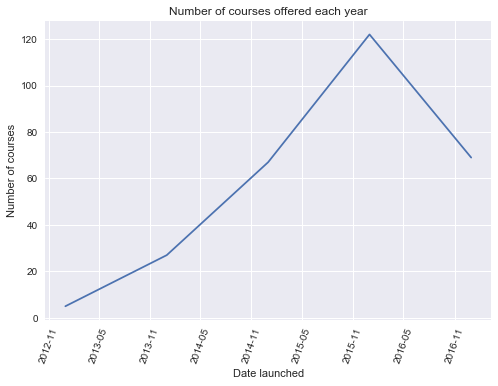

In [15]:
plt.plot(df.groupby(Grouper(key="Launch Date", freq='A'))["Course Number"].count());
plt.xticks(rotation=70);
plt.title("Number of courses offered each year");
plt.ylabel("Number of courses");
plt.xlabel("Date launched");

The data ends in August, which is likely to be the reason for the dip at the end.

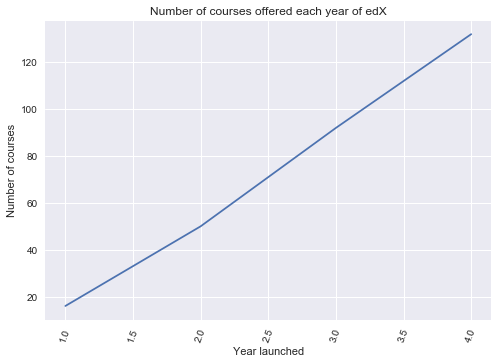

In [16]:
plt.plot(df.groupby("Year")["Course Number"].count());
plt.xticks(rotation=70);
plt.title("Number of courses offered each year of edX");
plt.ylabel("Number of courses");
plt.xlabel("Year launched");

When we look by academic year instead of calendar year, we can see that the number of courses is steadily going up.

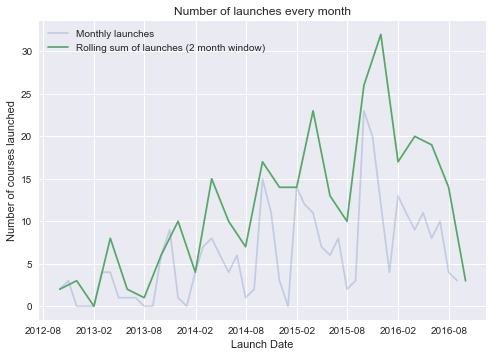

In [17]:
df2= df.set_index("Launch Date")
monthly_launches = df2.resample("M").count()["Institution"]

plt.plot(monthly_launches, alpha=0.25)
plt.plot(monthly_launches.resample("2M").sum())
plt.title("Number of launches every month")
plt.xlabel("Launch Date")
plt.ylabel("Number of courses launched")
plt.legend(["Monthly launches", "Rolling sum of launches (2 month window)"]);

It seems that there is some periodicity in the launch dates of course, with many being launched at at or during the spring and fall terms, and fewer during summer or winter vacations.

## Number of participants
(Number of participants is defined as the number of people who access the course content)

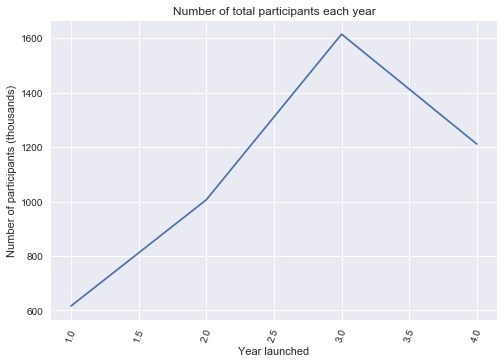

In [18]:
plt.plot(df.groupby("Year")["Participants (Course Content Accessed)"].sum()/1000);
plt.xticks(rotation=70);
plt.title("Number of total participants each year");
plt.ylabel("Number of participants (thousands)");
plt.xlabel("Year launched");

Although there are more courses being offered, participation numbers have dipped in the fourth year. The third year had one truly massive course which might have inflated the third year value.

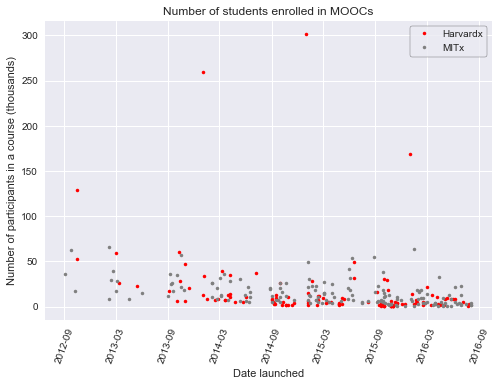

In [19]:
plt.plot_date(x=df[df.Institution=="HarvardX"]["Launch Date"], y=df[df.Institution=="HarvardX"]["Participants (Course Content Accessed)"]/1000, marker=".", color="red");
plt.plot_date(x=df[df.Institution=="MITx"]["Launch Date"], y=df[df.Institution=="MITx"]["Participants (Course Content Accessed)"]/1000, marker=".", color="grey");
plt.xticks(rotation=70);
plt.title("Number of students enrolled in MOOCs");
plt.ylabel("Number of participants in a course (thousands)");
plt.xlabel("Date launched");
plt.legend(["Harvardx", "MITx"], frameon=True, edgecolor="black");

The number of students has also increased over the years. It seems that this is due to an increase in more, small classes rather than a small number of huge classes, although a few HarvardX classes have been very large.

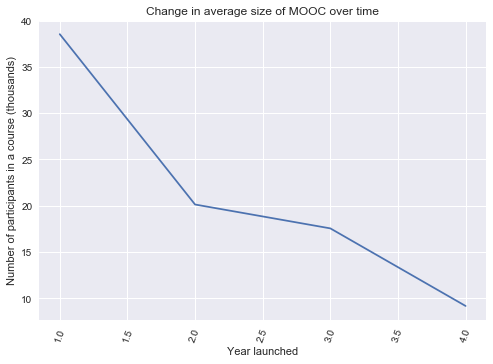

In [20]:
plt.plot(df.groupby("Year")["Participants (Course Content Accessed)"].mean()/1000);
plt.xticks(rotation=70);
plt.title("Change in average size of MOOC over time");
plt.ylabel("Number of participants in a course (thousands)");
plt.xlabel("Year launched");

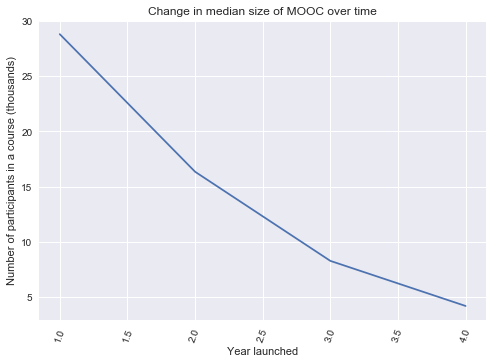

In [21]:
plt.plot(df.groupby("Year")["Participants (Course Content Accessed)"].median()/1000);
plt.xticks(rotation=70);
plt.title("Change in median size of MOOC over time");
plt.ylabel("Number of participants in a course (thousands)");
plt.xlabel("Year launched");

It appears that the size of MOOCs is decreasing over time. Although some of the largest courses have occurred in the later years, the average and median course sizes is going down. Perhaps this is because there are more classes to choose from.

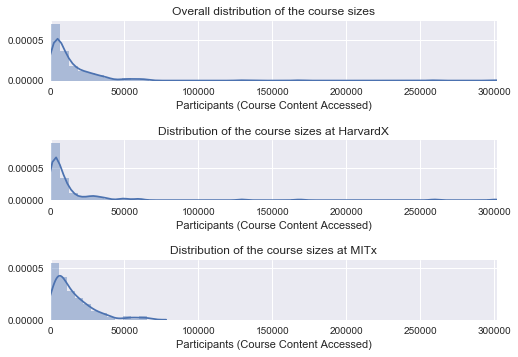

In [22]:
plt.subplot(3,1,1)
x= sns.distplot(df["Participants (Course Content Accessed)"], hist=True)
plt.title("Overall distribution of the course sizes")
plt.xlim([100,302000])
#x.set_xscale("log")

plt.subplot(3,1,2)
x=sns.distplot(df[df["Institution"]=="HarvardX"]["Participants (Course Content Accessed)"], hist=True)
plt.title("Distribution of the course sizes at HarvardX")
plt.xlim([100,302000])
#x.set_xscale("log")

plt.subplot(3,1,3)
x=sns.distplot(df[df["Institution"]=="MITx"]["Participants (Course Content Accessed)"], hist=True)
plt.title("Distribution of the course sizes at MITx");
plt.xlim([100,302000])
#x.set_xscale("log")

plt.subplots_adjust(hspace=1)


Although some of the largest courses are at HarvardX, MITx courses tend to be larger than HarvardX classes.

## Percent of students who "finished" the course
Or at least got 50% through...

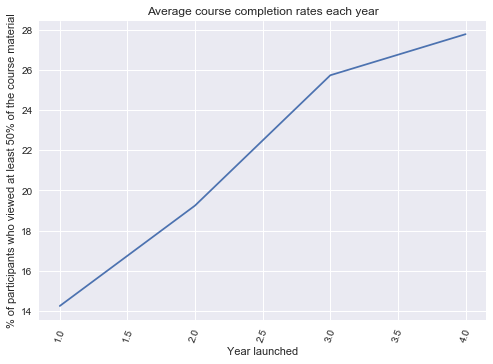

In [23]:
plt.plot(df.groupby("Year")["% Audited"].mean());
plt.xticks(rotation=70);
plt.title("Average course completion rates each year");
plt.ylabel("% of participants who viewed at least 50% of the course material");
plt.xlabel("Year launched");

Students have also become more dedicated-- few students in the first two years got more than half-way through the course, but students have become more likely to complete more of the courses that they sign up for. 

Possibly students started off just signing up as a novelty without plans to complete it, students adapted to the format, or the format adapted tot he students by implementing best practices. For example, now most MOOCs on edX have a blurb describing how to succeed in the course.

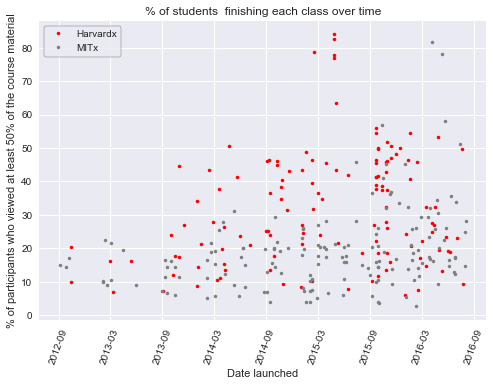

In [24]:
plt.plot_date(x=df[df.Institution=="HarvardX"]["Launch Date"], y=df[df.Institution=="HarvardX"]["% Audited"], marker=".", c="red")
plt.plot_date(x=df[df.Institution=="MITx"]["Launch Date"], y=df[df.Institution=="MITx"]["% Audited"], marker=".", c="grey")
plt.xticks(rotation=70);
plt.title("% of students  finishing each class over time");
plt.ylabel("% of participants who viewed at least 50% of the course material");
plt.xlabel("Date launched");
plt.legend(["Harvardx", "MITx"], frameon=True, edgecolor="black");

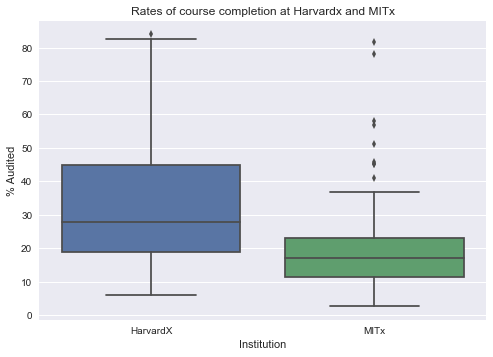

In [25]:
sns.boxplot(data=df, x="Institution", y="% Audited");
plt.title("Rates of course completion at Harvardx and MITx");


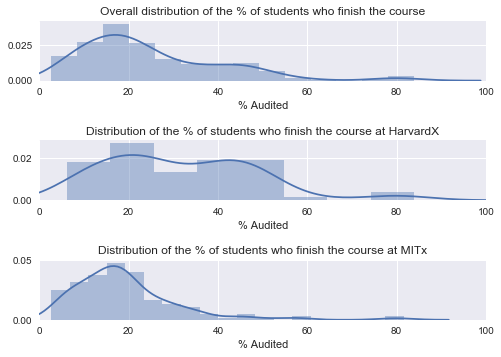

In [26]:
plt.subplot(3,1,1)
sns.distplot(df["% Audited"], hist=True)
plt.title("Overall distribution of the % of students who finish the course")
plt.xlim([0,100]);

plt.subplot(3,1,2)
sns.distplot(df[df["Institution"]=="HarvardX"]["% Audited"], hist=True)
plt.title("Distribution of the % of students who finish the course at HarvardX")
plt.xlim([0,100]);

plt.subplot(3,1,3)
sns.distplot(df[df["Institution"]=="MITx"]["% Audited"], hist=True)
plt.title("Distribution of the % of students who finish the course at MITx");
plt.subplots_adjust(hspace=1)
plt.xlim([0,100]);


MIT classes seem to have lower rates of completion than Harvard classes.

## Certified students
Although edX courses are offered for free to audit, students can also opt to pay for a certificate. I believe this is one way edX gets funding (in addition to donations), so it's important to look at. 

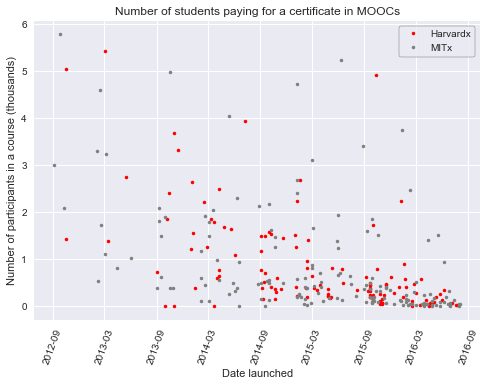

In [27]:
plt.plot_date(x=df[df.Institution=="HarvardX"]["Launch Date"], y=df[df.Institution=="HarvardX"]["Certified"]/1000, marker=".", color="red");
plt.plot_date(x=df[df.Institution=="MITx"]["Launch Date"], y=df[df.Institution=="MITx"]["Certified"]/1000, marker=".", color="grey");
plt.xticks(rotation=70);
plt.title("Number of students paying for a certificate in MOOCs");
plt.ylabel("Number of participants in a course (thousands)");
plt.xlabel("Date launched");
plt.legend(["Harvardx", "MITx"], frameon=True, edgecolor="black");

Classes with lots of certified students include many of the larger courses, including computer science and social science.

In [28]:
df[df["Certified"]>4000]

,Institution,Course Number,Launch Date,Course Title,Instructors,Course Subject,Year,Honor Code Certificates,Participants (Course Content Accessed),Audited (> 50% Course Content Accessed),Certified,% Audited,% Certified,% Certified of > 50% Course Content Accessed,% Played Video,% Posted in Forum,% Grade Higher Than Zero,Total Course Hours (Thousands),Median Hours for Certification,Median Age,% Male,% Female,% Bachelor's Degree or Higher
1,MITx,6.00x,2012-09-26,Introduction to Computer Science and Programming,"Eric Grimson, John Guttag, Chris Terman",Computer Science,1,1,62709,8949,5783,14.27,9.22,64.05,89.14,14.38,39.50,884.04,78.53,28.0,83.50,16.50,63.04
4,HarvardX,PH207x,2012-10-15,Health in Numbers: Quantitative Methods in Cli...,"Earl Francis Cook, Marcello Pagano","Government, Health, and Social Science",1,1,52521,10729,5058,20.44,9.64,47.12,77.45,15.98,32.52,804.41,76.10,32.0,56.78,43.22,88.33
7,MITx,14.73x,2013-02-12,The Challenges of Global Poverty,"Esther Duflo, Abhijit Banerjee","Government, Health, and Social Science",1,1,29044,6510,4607,22.41,15.86,70.60,83.24,13.89,39.38,279.22,40.30,30.0,53.76,46.24,81.94
9,HarvardX,ER22x,2013-03-02,Justice,Michael Sandel,"Humanities, History, Design, Religion, and Edu...",1,1,58779,9425,5438,16.05,9.26,51.07,---,21.86,20.98,186.61,13.67,30.0,60.42,39.58,69.78
27,MITx,6.00.1x,2013-10-16,Introduction to Computer Science and Programming,"Eric Grimson, John Guttag",Computer Science,2,1,57147,8248,4975,14.43,8.71,60.23,76.86,9.47,43.16,523.56,53.05,28.0,82.95,17.05,62.73
57,MITx,MAS.S69x,2014-05-12,Big Data and Social Physics,Sandy Pentland,"Government, Health, and Social Science",2,1,30456,9494,4055,31.17,13.31,36.14,64.8,4.67,13.31,34.79,2.10,30.0,80.39,19.61,81.37
103,MITx,6.00.1x,2015-01-07,Introduction to Computer Science and Programmi...,"Eric Grimson, John Guttag",Computer Science,3,1,49529,8924,4738,18.02,9.57,53.07,77.76,8.91,49.04,485.67,48.96,27.0,82.56,17.44,67.27
153,MITx,6.00.1x,2015-06-10,Introduction to Computer Science and Programming,"Eric Grimson, John Guttag",Computer Science,3,1,53964,9583,5243,17.76,9.72,54.68,77.31,7.60,49.00,895.01,86.65,25.0,78.53,21.47,64.59
193,HarvardX,SPU30x,2015-10-13,Super-Earths and Life,Dimitar Sasselov,"Science, Technology, Engineering, and Mathematics",4,1,29176,11250,4918,38.56,16.86,43.72,51.96,26.62,52.35,109.00,13.47,26.0,60.09,39.91,44.95


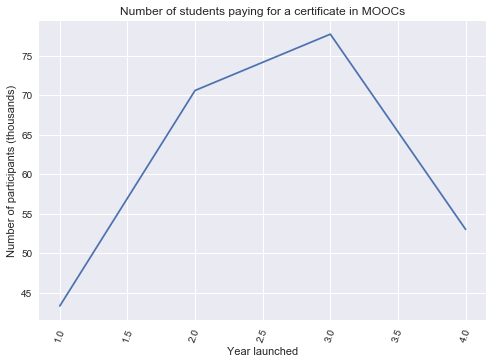

In [29]:
plt.plot(df.groupby("Year")["Certified"].sum()/1000);
plt.xticks(rotation=70);
plt.title("Number of students paying for a certificate in MOOCs");
plt.ylabel("Number of participants (thousands)");
plt.xlabel("Year launched");

The number of students getting certificates was increasing over time, but dipped in the fourth year. Is this because enrollment is down, or because the rate of certification is decreasing, or both?

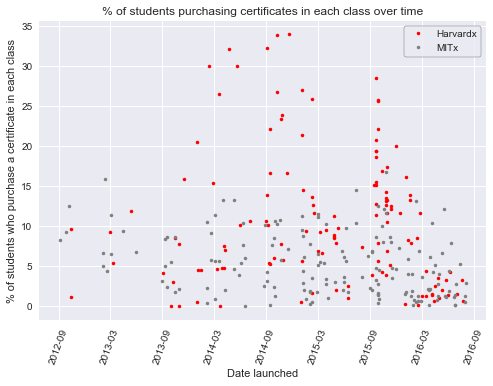

In [30]:
plt.plot_date(x=df[df.Institution=="HarvardX"]["Launch Date"], y=df[df.Institution=="HarvardX"]["% Certified"], marker=".", color = "red");
plt.plot_date(x=df[df.Institution=="MITx"]["Launch Date"], y=df[df.Institution=="MITx"]["% Certified"], marker=".", color = "grey");

plt.xticks(rotation=70);
plt.title("% of students purchasing certificates in each class over time");
plt.ylabel("% of students who purchase a certificate in each class");
plt.xlabel("Date launched");
plt.legend(["Harvardx", "MITx"], frameon=True, edgecolor="black");


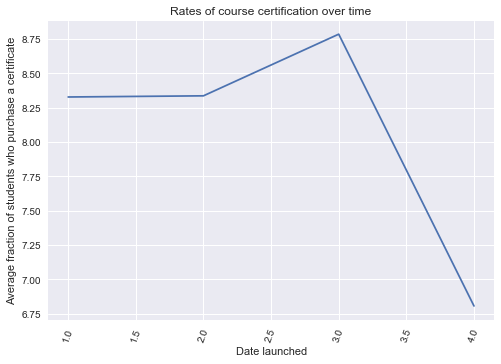

In [31]:
plt.plot(df.groupby("Year")["% Certified"].mean());
plt.xticks(rotation=70);
plt.title("Rates of course certification over time");
plt.ylabel("Average fraction of students who purchase a certificate");
plt.xlabel("Date launched");

Both enrollment and rates of certification have decreased. The decrease in overall certification amounts is likely to be driven by both factors.

Which classes have a high proportion who decide to pay for the course? They are mostly smaller humanities courses at Harvard.

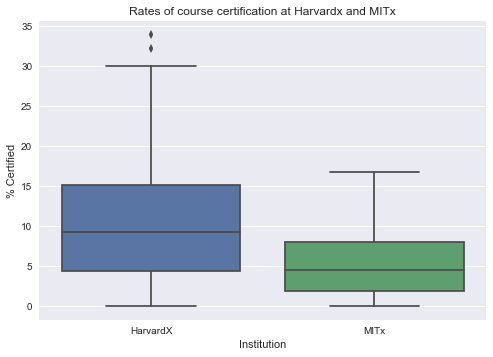

In [32]:
sns.boxplot(data=df, x="Institution", y="% Certified");
plt.title("Rates of course certification at Harvardx and MITx");

In [33]:
df[df["% Certified"]>25]["Participants (Course Content Accessed)"].mean()

3436.3846153846152

In [34]:
df[df["% Certified"]>25]

,Institution,Course Number,Launch Date,Course Title,Instructors,Course Subject,Year,Honor Code Certificates,Participants (Course Content Accessed),Audited (> 50% Course Content Accessed),Certified,% Audited,% Certified,% Certified of > 50% Course Content Accessed,% Played Video,% Posted in Forum,% Grade Higher Than Zero,Total Course Hours (Thousands),Median Hours for Certification,Median Age,% Male,% Female,% Bachelor's Degree or Higher
39,HarvardX,SW12.3x,2014-02-13,Cosmopolitan Tang: Aristocratic Culture,"Peter Bol, Bill Kirby","Humanities, History, Design, Religion, and Edu...",2,1,7422,3221,2226,43.43,30.01,63.18,77.16,29.14,50.29,33.76,8.99,34.0,58.97,41.03,79.40
48,HarvardX,SW12.4x,2014-03-20,A New National Culture,"Peter Bol, Bill Kirby","Humanities, History, Design, Religion, and Edu...",2,1,6753,2552,1788,37.81,26.49,62.19,76.01,22.71,45.74,34.82,11.42,34.0,60.51,39.49,80.78
56,HarvardX,SW12.5x,2014-04-24,From Global Empire to Global Economy,"Peter Bol, Bill Kirby","Humanities, History, Design, Religion, and Edu...",2,1,5256,2649,1686,50.44,32.10,62.21,75.32,28.69,48.95,24.76,9.09,35.0,64.35,35.65,82.04
59,HarvardX,SW12.6x,2014-05-22,The Last Empire,"Peter Bol, Bill Kirby","Humanities, History, Design, Religion, and Edu...",2,1,5446,2244,1637,41.24,30.09,63.73,76.75,24.22,49.72,31.69,11.70,35.0,60.97,39.03,80.56
74,HarvardX,SW12.7x,2014-09-04,"Invasions, Rebellions, and the end of Imperial...","Peter Bol, Bill Kirby","Humanities, History, Design, Religion, and Edu...",3,1,4662,2148,1505,46.10,32.30,61.45,80.08,33.98,52.26,22.93,8.68,38.0,63.87,36.13,82.25
87,HarvardX,HUM2.3x,2014-10-08,The Ancient Greek Hero in 24 Hours (Hours 12-1...,Gregory Nagy,"Humanities, History, Design, Religion, and Edu...",3,1,1559,697,417,44.85,26.83,59.54,43.18,2.90,33.72,3.20,1.77,34.0,50.35,49.65,66.91
89,HarvardX,SW12.8x,2014-10-09,Creating China: The Birth of a Nation,"Peter Bol, Bill Kirby","Humanities, History, Design, Religion, and Edu...",3,1,4515,2081,1528,46.13,33.87,62.85,78.36,31.46,51.05,23.92,9.54,37.0,64.33,35.67,82.68
98,HarvardX,SW12.9x,2014-11-20,Communist Liberations,"Peter Bol, Bill Kirby","Humanities, History, Design, Religion, and Edu...",3,1,4248,1835,1442,43.24,33.98,65.12,79.76,30.14,50.49,23.03,9.76,37.0,67.11,32.89,82.98
101,HarvardX,1368.3x,2015-01-05,"Saving Schools: History, Politics, and Policy ...",Paul Peterson,"Humanities, History, Design, Religion, and Edu...",3,1,1483,641,400,43.25,26.99,62.25,64.51,12.75,49.73,3.40,4.67,34.0,46.56,53.44,80.97
117,HarvardX,1368.4x,2015-02-09,"Saving Schools: History, Politics, and Policy ...",Paul Peterson,"Humanities, History, Design, Religion, and Edu...",3,1,1465,578,380,39.48,25.96,64.71,62.91,19.06,45.22,3.16,4.86,35.0,48.50,51.50,81.63


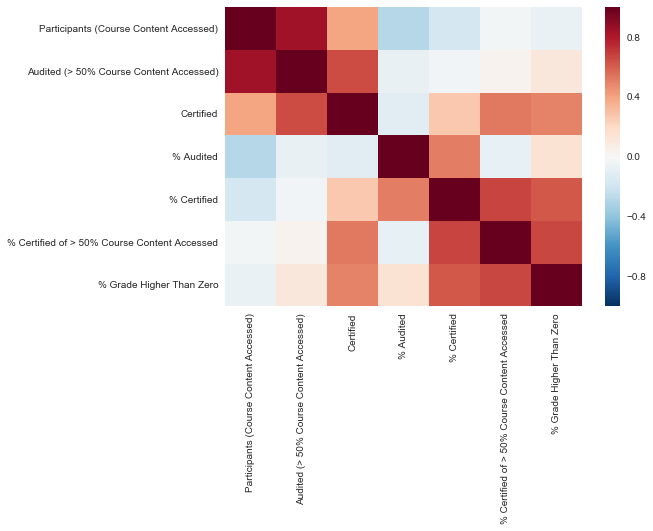

In [35]:
sns.heatmap(df[['Participants (Course Content Accessed)',
       'Audited (> 50% Course Content Accessed)', 'Certified', '% Audited',
       '% Certified', '% Certified of > 50% Course Content Accessed',
        '% Grade Higher Than Zero']].corr());

Larger classes do seem to be inversely correlated with completion rates as well as certification rates. MITx classes are larger and have lower rates of completion. Perhaps "hot" sounding classes attract lots of people to sign up even though they are not motivated to finish the class. Or, there could be confounding variables (MITx classes might be harder, and since they are also larger, this causes the size to be inversely correlated with completion rate).
edX could experiment to determine correlation vs causation by capping sizes on courses. If larger classes do appear to cause lower completion rate, edX could try interventions such as offering multiple concurrent sections of a class with more staff for each, facilitating study groups, etc.

### Assuming that each certificate brings in $100 of profit, how is edX doing over time? 

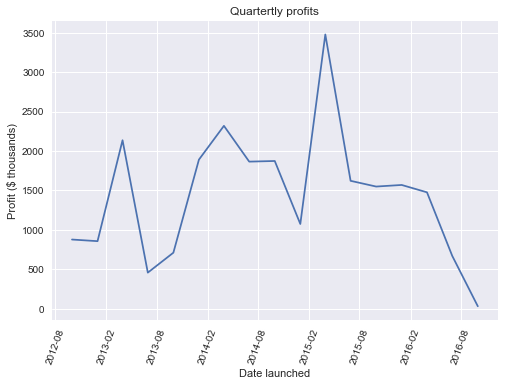

In [36]:
plt.plot(df.groupby(Grouper(key="Launch Date", freq='Q'))["Certified"].sum()/10);
plt.xticks(rotation=70);
plt.title("Quartertly profits");
plt.ylabel("Profit ($ thousands)");
plt.xlabel("Date launched");


The variability might be due to the periodicity in start dates that was observed before.

# What makes a class popular?

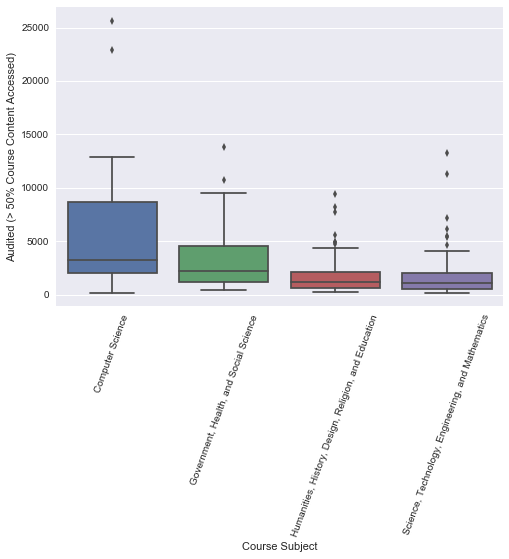

In [37]:
sns.boxplot(data=df, x="Course Subject", y="Audited (> 50% Course Content Accessed)")
plt.xticks(rotation=70);

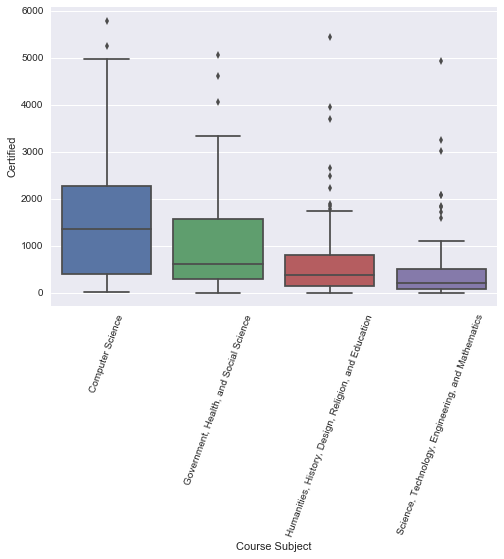

In [38]:
sns.boxplot(data=df, x="Course Subject", y="Certified")
plt.xticks(rotation=70);

Computer science courses tend to have the highest enrollments as well as number of paying students.

## What course titles are appealing to students?

Can I identify what keywords in the course titles are associated with increased numbers of paying students? I will use a count vectorizer followed by a linear regressor to extract words from the course titles and find which are predictive of the number of students who will go on to purchase a certificate. I am choosing this metric, because I think that the financial success is most correlated with this metric.

In [39]:
print("Number of unique words in the course titles:")
print(len(set(" ".join(df["Course Title"].values).split())))

Number of unique words in the course titles:
552


There are too many words here for me to use with the few data points I have. 
Lasso will hopefully discard all but the most useful

In [41]:
# Setting a seed here for reproducibility in the splits
np.random.seed(0)
df["split"]=np.random.random(len(df))

# Since the enrollments vary by orders of magnitude, 
# it makes sense to fit the log of the enrollment numbers 
# log = True fits the log(numbers), log = False fits the raw numbers.
# Note: Fitting the log(numbers) also is faster.
log = True   

In [42]:
# A pipeline allows me to easily search for the best value for alpha.
pl = Pipeline([
    ("vec", CountVectorizer(stop_words="english")),
    ("reg", Lasso(max_iter=100000))
])

X = df["Course Title"]
X_train = df["Course Title"][df["split"]<0.8]
if log:
    y = np.log(df.Certified+1)
    y_train = y[df["split"]<0.8]
    parameters = dict(reg__alpha= [0.001, 0.005, 0.01, 0.05, 0.1])
else:
    y = df.Certified
    y_train=y[df["split"]<0.8]
    parameters = dict(reg__alpha= [0.01, 0.1, 0.5, 1.0, 10])

gs_cv=GridSearchCV(pl, param_grid=parameters, cv=10, scoring="neg_mean_squared_error")

gs_cv.fit(X_train, y_train)
print("Best score: ",gs_cv.best_score_)
print("Best parameters: ", gs_cv.best_params_)

Best score:  -2.09132491751
Best parameters:  {'reg__alpha': 0.01}


In [43]:
#gs_cv.cv_results_

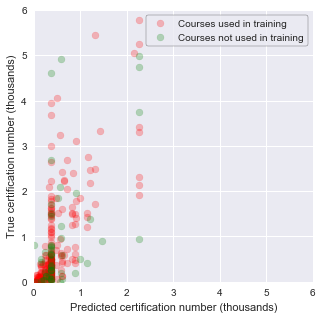

In [44]:
if log:
    pred = np.exp(gs_cv.predict(X))-1
else:
    pred = gs_cv.predict(X)

plt.figure(figsize=[5,5]);

plt.scatter(pred[df["split"]<0.8]/1000, df[df["split"]<0.8]["Certified"]/1000, color = "red", alpha=0.25);
plt.scatter(pred[df["split"]>=0.8]/1000, df[df["split"]>=0.8]["Certified"]/1000, color = "green", alpha=0.25);
plt.legend(["Courses used in training", "Courses not used in training"], frameon=True, edgecolor="black")

plt.xlabel("Predicted certification number (thousands)");
plt.xlim([0,6]);
plt.ylabel("True certification number (thousands)");
plt.ylim([0,6]);

In [45]:
print("Correlation matrix for test set:")
print(np.corrcoef(y[df["split"]>=0.8]/1000, pred[df["split"]>=0.8]/1000))

print("Correlation matrix for training set:")
print(np.corrcoef(y[df["split"]<0.8]/1000, pred[df["split"]<0.8]/1000))

Correlation matrix for test set:
[[ 1.          0.40190632]
 [ 0.40190632  1.        ]]
Correlation matrix for training set:
[[ 1.          0.59111782]
 [ 0.59111782  1.        ]]


Although the gridsearch did cross validation, it is somewhat overfitting to the training data. Now that we have a value for the alpha, let's train on the whole data set to have a bit more data.

In [46]:
vec= CountVectorizer(stop_words="english")
vec.fit_transform(X, y)

reg = Lasso(alpha=gs_cv.best_params_['reg__alpha'])
reg.fit(vec.fit_transform(X, y), y)

feature_list= []
for i in range(len(reg.coef_)):
    if np.abs(reg.coef_[i])>1e-3:
        feature_list.append((reg.coef_[i], vec.get_feature_names()[i]))

print("Number of features kept by lasso:", len(feature_list))

sorted_features = sorted(feature_list)
for i, j in sorted_features:
    print ("{:<17}: {:9.4f}".format(j, i))

Number of features kept by lasso: 54
alumni           :   -2.9631
experiences      :   -1.3483
amplification    :   -1.2882
applications     :   -1.0975
application      :   -1.0669
central          :   -0.9481
genomics         :   -0.9208
poetry           :   -0.8853
optical          :   -0.8752
quantum          :   -0.7812
control          :   -0.7711
field            :   -0.6074
aerodynamics     :   -0.5688
einstein         :   -0.5384
materials        :   -0.5258
religions        :   -0.4871
biology          :   -0.3994
nights           :   -0.3475
mobile           :   -0.3420
work             :   -0.2412
introduction     :   -0.2369
education        :   -0.2332
england          :   -0.1777
revolution       :   -0.1381
analysis         :   -0.0951
speed            :   -0.0553
press            :   -0.0489
harvardx         :   -0.0484
mechanics        :   -0.0339
state            :   -0.0220
explorations     :   -0.0052
trust            :    0.0018
promise          :    0.0042
supply

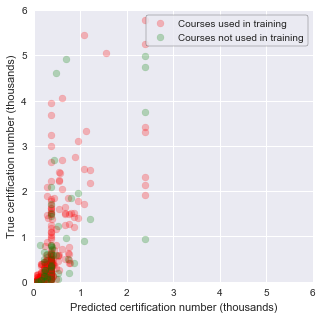

In [47]:
if log:
    pred = np.exp(reg.predict(vec.transform(X)))-1
else:
    pred = reg.predict(vec.transform(X))

plt.figure(figsize=[5,5]);

plt.scatter(pred[df["split"]<0.8]/1000, df[df["split"]<0.8]["Certified"]/1000, color = "red", alpha=0.25);
plt.scatter(pred[df["split"]>=0.8]/1000, df[df["split"]>=0.8]["Certified"]/1000, color = "green", alpha=0.25);
plt.legend(["Courses used in training", "Courses not used in training"], frameon=True, edgecolor="black")


plt.xlabel("Predicted certification number (thousands)");
plt.xlim([0,6]);
plt.ylabel("True certification number (thousands)");
plt.ylim([0,6]);


In [48]:
print("Correlation matrix for all data:")
print(np.corrcoef(df["Certified"]/1000, pred/1000))

Correlation matrix for all data:
[[ 1.          0.66600723]
 [ 0.66600723  1.        ]]


In [49]:
def predict_by_title(my_title):
    my_title_predict = reg.predict(vec.transform([my_title]))
    if log:
        my_title_predict = np.exp(my_title_predict)-1
    print("\""+my_title +"\""+ " has a predicted certification of {:.0f}".format(my_title_predict[0]))

In [50]:
predict_by_title("The fundamentals of programming for the analytics of justice")
predict_by_title("Poetry: the central application of alumni experences")

"The fundamentals of programming for the analytics of justice" has a predicted certification of 11138
"Poetry: the central application of alumni experences" has a predicted certification of 0


## Limitations


The data set is very small, so the predictive power for certification numbers from course titles is very limited. For example, it's not that there are many courses about justice that are all popular, but rather one course called "Justice" that has been relatively popular over the years. Even this one offering has had a high variability in the number certified, which places a limit on how well a title could predict the number of certified students (adding in the year of the course offered might be a useful feature, for example). For the model to be predictive, it would need more data with fewer unique words. The features should appear in different combinations.

In [51]:
df[df["Course Title"].str.contains("Justice")]

,Institution,Course Number,Launch Date,Course Title,Instructors,Course Subject,Year,Honor Code Certificates,Participants (Course Content Accessed),Audited (> 50% Course Content Accessed),Certified,% Audited,% Certified,% Certified of > 50% Course Content Accessed,% Played Video,% Posted in Forum,% Grade Higher Than Zero,Total Course Hours (Thousands),Median Hours for Certification,Median Age,% Male,% Female,% Bachelor's Degree or Higher,split
9,HarvardX,ER22x,2013-03-02,Justice,Michael Sandel,"Humanities, History, Design, Religion, and Edu...",1,1,58779,9425,5438,16.05,9.26,51.07,---,21.86,20.98,186.61,13.67,30.0,60.42,39.58,69.78,0.383442
54,HarvardX,ER22.1x,2014-04-08,Justice,Michael Sandel,"Humanities, History, Design, Religion, and Edu...",2,1,35409,4767,2485,13.47,7.02,45.69,67.31,19.05,17.85,145.01,20.13,29.0,58.00,42.00,67.17,0.208877
189,HarvardX,ER22x,2015-10-01,Justice,Michael Sandel,"Humanities, History, Design, Religion, and Edu...",4,1,30699,3607,1726,11.75,5.62,45.77,66.93,10.50,20.25,109.74,16.72,26.0,57.56,42.44,66.50,0.311945


There were some apparent declines in the number of participants and certified students in the last year, but it is possible that these might be artifacts of being at the end of the data set. For example, some classes are self-paced and might not have been finished or closed enrollment at the time of the dataset being finalized. Getting more data would allow us to better understand if these dips are acutal trends or artifacts. Since the enrollment numbers per class are highly variable, the offering of even just one class (for example, CS50x) can be 20-25% of a typical year's enrollment. The offering of such courses can create huge spikes in the data that, given the small number of years in the dataset, can hide trends.

## Future directions
It appears that in some cases, when a course is offered multiple times, it has a decrease in participation. It would be interesting to look at this further and compare it with the cost of re-hosting a course (which is likely low compared to the cost of launching a new course).

It would also be interesting to analyze the demographics of different courses. Which appeal to older students? Which appeal to female students? Which appeal to students who already hold degrees?

edX has since offered another 1.5 years of classes, which could be added to this data set. In addition, there are a number of other MOOC platforms (Udacity, Udemy, Coursera, etc.) which would be fascinating to compare to. Is the novelty of MOOCs wearing off, or are students moving to other platforms?

Additionally, it would be interesting to delve deeper into why certification rates are decreasing even though completion rates are increasing. edX might do surveys to determine if students are taking these courses simply to learn rather than for professional development, or if students don't feel the need to get an official certificate to advertise their learning.